# Evaluating Classification Models

## Case Study: Credit Card Fraud

Data set of credit card transactions from Vesta.

In [1]:
! cd data && wget https://datasci112.stanford.edu/data/fraud.csv

import pandas as pd

df_fraud = pd.read_csv("data/fraud.csv")
df_fraud

--2025-08-18 19:03:54--  https://datasci112.stanford.edu/data/fraud.csv
Resolving datasci112.stanford.edu (datasci112.stanford.edu)... 54.81.116.232
Connecting to datasci112.stanford.edu (datasci112.stanford.edu)|54.81.116.232|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://web.stanford.edu/class/datasci112//data/fraud.csv [following]
--2025-08-18 19:03:55--  https://web.stanford.edu/class/datasci112//data/fraud.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5163723 (4.9M) [text/csv]
Saving to: ‘fraud.csv’

fraud.csv           100%[===================>]   4.92M   759KB/s    in 8.9s    

2025-08-18 19:04:08 (564 KB/s) - ‘fraud.csv’ saved [5163723/5163723]



,card4,card6,P_emaildomain,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
0,visa,debit,gmail.com,62.950,139.0,110.0,0.0,0.0,135.0,93.0,0.0,0.0,93.0,0.0,93.0,0.0,637.0,114.0,0
1,visa,debit,,35.950,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0
2,visa,debit,yahoo.com,117.000,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,1
3,visa,debit,hotmail.com,54.500,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
4,visa,debit,gmail.com,255.000,1.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,3.0,1.0,20.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59049,mastercard,debit,gmail.com,20.522,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
59050,mastercard,credit,yahoo.com,50.000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0
59051,mastercard,debit,icloud.com,97.950,2.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,15.0,2.0,0
59052,visa,debit,gmail.com,16.723,1.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1


Goal: Predict `isFraud`, where 1 indicates a fraudulent transaction.

## Classification Model

We can use $k$-nearest neighbors for classification:

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ["card4", "card6", "P_emaildomain"]),
        remainder="passthrough"),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

## Training a Classifier

In [3]:
X_train = df_fraud.drop(columns=["isFraud"], axis="column")
y_train = df_fraud["isFraud"]

In [4]:
from sklearn.model_selection import cross_val_score

cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="accuracy",
    cv=10
).mean()

np.float64(0.9681816450957752)

How is the accuracy so high?

## A Closer Look

Let's take a closer look at the labels.

In [5]:
y_train.value_counts()

isFraud
0    56935
1     2119
Name: count, dtype: int64

The vast majority of transactions are normal!

If we just predicted that every transaction is normal, the accuracy would be $1 - \frac{2119}{59054} = .964$.

Even though such predictions would be accurate *overall*, it is inaccurate for fraudulent transactions. A good model is "accurate for every class".

## Precision and Recall

We need a score that measures "accuracy for class $c$".

There are at least tow reasonable definitions:

- **precision**: $P(\textrm{correct|predicted class }c)$ <br />
Among the observations that were predicted to be in class $c$, what proportion actually were?
- **recall**: $P(\textrm{correct|actual class }c)$ <br />
Among the observations that were actually in class $c$, what proportion were predicted to be? 

## A Geometric Look at Precision and Recall

![Precision and Recall](data/precision-and-recall.png)

**precision** $= \mathsf{\frac{TP}{TP + FP}}$ <br />
**recall** $= \mathsf{\frac{TP}{TP + FN}}$

## Precision and Recall by Hand

To check our understanding of these definitions, let's calculate a few precisions and recalls by hand.

First, summarize the results by the **confusion matrix.**

In [7]:
from sklearn.metrics import confusion_matrix

pipeline.fit(X_train, y_train)
y_train_ = pipeline.predict(X_train)
cm = confusion_matrix(y_train, y_train_)

In [16]:
print("actually in class 0: ", cm[0:1, :]) # actually in class 0
print("actually in class 1: ", cm[1:2, :]) # actually in class 1
print("predicted class 0: ", cm[:, 0:1]) # predicted class 0
print("predicted class 1: ", cm[:, 1:2]) # predicted class 1

actually in class 0:  [[56816   119]]
actually in class 1:  [[1523  596]]
predicted class 0:  [[56816]
 [ 1523]]
predicted class 1:  [[119]
 [596]]


- What is the (training) accuracy?
- What is the precision for normal transactions?
- What is the recall for normal transactions?
- What is the precision for fraudulent transactions?
- What is the recall for fraudulent transactions?

In [ ]:
# calculate the training accuracy
# TP + TN / (TP + TN + FP + FN)
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print("Training accuracy: ", accuracy)

Training accuracy:  0.9721949402242016


In [ ]:
# calculate the precision for normal transactions
# TP / (TP + FP)
precision_normal = cm[0, 0] / (cm[0, 0] + cm[1, 0])
print("Precision for normal transactions: ", precision_normal)

Precision for normal transactions:  0.9738939645862973


In [19]:
# calculate the recall for normal transactions
# TP / (TP + FN)
recall_normal = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("Recall for normal transactions: ", recall_normal)

Recall for normal transactions:  0.9979098972512515


In [20]:
# calculate the precision for fraudulent transactions
precision_fraudulent = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print("Precision for fraudulent transactions: ", precision_fraudulent)

Precision for fraudulent transactions:  0.8335664335664336


In [21]:
# calculate the recall for fraudulent transactions
recall_fraudulent = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print("Recall for fraudulent transactions: ", recall_fraudulent)

Recall for fraudulent transactions:  0.28126474752241626


*Note:* Each class has its own precision and recall!

## Tradeoff between Precision and Recall

Can you imagine a classifier that always has 100% recall for $c$, no matter thd data?

In general, if the model classifies more observations as $c$,

- recall (for class $c$) $\uparrow$
- precision (for class $c$) $\downarrow$

How do we compare two classifiers, if one has higher precision and the other has higher recall?

The **F1 score** combines precision and recall into a single score:

$$
\textsf{F1 score = harmonic mean of precision and recall}
$$

$$
= \frac{1}{\frac{1}{2}(\frac{1}{\mathsf{precision}} + \frac{1}{\mathsf{recall}})}
$$

*So the F1 score of the classifier for fraudulent transactions is*
$$
= \frac{1}{\frac{1}{2}(\frac{1}{\mathsf{.835}} + \frac{1}{\mathsf{.281}})} \approx 420\%
$$

To achieve a high F1 score, both precision and recall have to be high. If either is low, then the harmonic mean will be low.

## Estimating Test Precision, Recall, and F1

Remember that each class has its own precision, recall, and F1.

But Scikit-Learn requires that the `scoring=` parameter be a single number.

For this, we can use

- `"precision_macro"`
- `"recall_macro"`
- `"f1_macro"`

which average the score over the classes.

*Example:*

In [22]:
cross_val_score(
    pipeline, X=X_train, y=y_train, cv=10, scoring='f1_macro'
).mean()

np.float64(0.647854958076209)

## Precision-Recall Curve

Another way to illustrate the tradeoff between precision and recall is to graph the **precision-recall curve.**

First, we need the predicted probabilities.

In [ ]:
# By default, Scikit-Learn classifies a transaction as fraud if this probability is > 0.5.
y_train_probs_ = pipeline.predict_proba(X_train)
y_train_probs_

array([[1. , 0. ],
       [1. , 0. ],
       [0.6, 0.4],
       ...,
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ]], shape=(59054, 2))

What if we instead used a threshold $t$ other than $0.5$?

Depending on which $t$ we pick, we'll get a different precision and recall. We can graph this tradeoff.

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_train, y_train_probs_[:, 1], pos_label=1)
precision

array([0.03588241, 0.33242681, 0.6359782 , 0.83356643, 0.9278607 ,
       1.        , 1.        ])

/tmp/ipykernel_5487/4046022738.py:7: RuntimeWarning: divide by zero encountered in divide
  "f1": 1 / (0.5 * (1 / precision + 1 / recall))


<Axes: xlabel='t', ylabel='f1'>

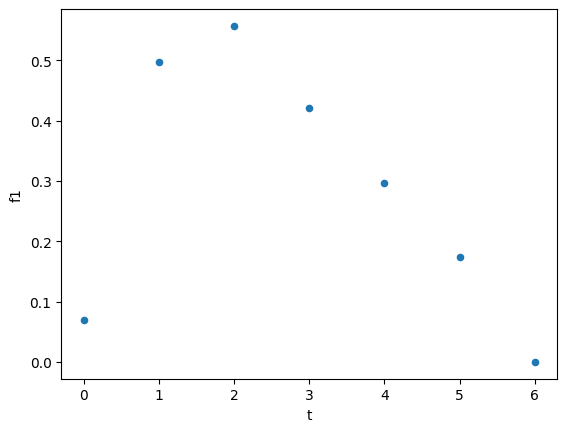

In [ ]:
import numpy as np

# t = 2에서 f1 score 극대화
pd.DataFrame({
    "t": np.arange(len(precision)),
    "precision": precision,
    "recall": recall,
    "f1": 1 / (0.5 * (1 / precision + 1 / recall))
}).plot.scatter(x="t", y="f1")

/tmp/ipykernel_5487/620669146.py:5: RuntimeWarning: divide by zero encountered in divide
  "f1": 1 / (0.5 * (1 / precision + 1 / recall))


<Axes: xlabel='precision', ylabel='recall'>

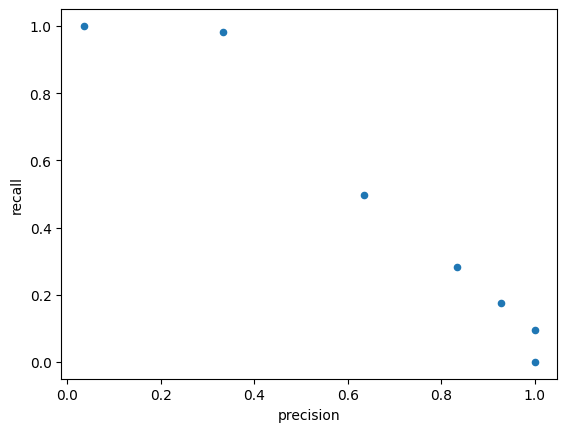

In [ ]:
# precision과 recall은 대체적으로 반비례 관계
pd.DataFrame({
    "t": np.arange(len(precision)),
    "precision": precision,
    "recall": recall,
    "f1": 1 / (0.5 * (1 / precision + 1 / recall))
}).plot.scatter(x="precision", y="recall")